All data used below to generate strategic insights

In [3]:
import os
import pandas as pd
import sqlite3
from google.cloud import bigquery
# Create BigQuery client
client = bigquery.Client(project="main-cocoa-308521")

Which stations show the biggest difference between weekday and weekend usage?

In [18]:
# Define your query — example: Citbike Trip dataset
query = """
WITH day_type_counts AS (
  SELECT
    start_station_name,
    CASE
      WHEN EXTRACT(DAYOFWEEK FROM starttime) IN (1, 7) THEN 'weekend'
      ELSE 'weekday'
    END AS day_type,
    COUNT(*) AS trip_count
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE start_station_name IS NOT NULL
  GROUP BY start_station_name, day_type
),

pivoted AS (
  SELECT
    start_station_name,
    SUM(CASE WHEN day_type = 'weekday' THEN trip_count ELSE 0 END) AS weekday_trips,
    SUM(CASE WHEN day_type = 'weekend' THEN trip_count ELSE 0 END) AS weekend_trips
  FROM day_type_counts
  GROUP BY start_station_name
)

SELECT
  start_station_name,
  weekday_trips,
  weekend_trips,
  ABS(weekday_trips - weekend_trips) AS usage_diff
FROM pivoted
ORDER BY usage_diff DESC
LIMIT 20
"""

# Run the query
day_query_job = client.query(query)

# Convert to pandas DataFrame
results = day_query_job.to_dataframe()
print(results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         start_station_name  weekday_trips  weekend_trips  usage_diff
0                                  5828994              0     5828994
1     Pershing Square North         393615          44462      349153
2           8 Ave & W 31 St         348074          53480      294594
3           W 41 St & 8 Ave         270784          40619      230165
4        Broadway & E 22 St         295823          71371      224452
5           8 Ave & W 33 St         276441          53937      222504
6           W 21 St & 6 Ave         308169          95626      212543
7        E 17 St & Broadway         317713         105621      212092
8           W 38 St & 8 Ave         242224          31357      210867
9           W 31 St & 7 Ave         236030          34265      201765
10    Lafayette St & E 8 St         285704          86551      199153
11       E 47 St & Park Ave         210173          15810      194363
12          W 33 St & 7 Ave         212412          36929      175483
13       Broadway & 

Classify each station-day into “Low”, “Medium”, or “High” demand based on trip volume percentiles. Then, analyze demand category distribution by borough.

In [21]:
# Define your query — example: Citbike Trip dataset
query = """

WITH trips_per_station_day AS (
  SELECT
    start_station_name,
    DATE(starttime) AS trip_date,
    COUNT(*) AS trip_count
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE end_station_name <> ''
  GROUP BY start_station_name, trip_date
),

percentiles AS (
  SELECT
    PERCENTILE_CONT(trip_count, 0.33) OVER() AS p33,
    PERCENTILE_CONT(trip_count, 0.66) OVER() AS p66
  FROM trips_per_station_day
  LIMIT 1
),

demand_classification AS (
  SELECT
    t.start_station_name,
    t.trip_date,
    t.trip_count,
    CASE
      WHEN t.trip_count <= p.p33 THEN 'Low'
      WHEN t.trip_count <= p.p66 THEN 'Medium'
      ELSE 'High'
    END AS demand_category
  FROM trips_per_station_day t
  CROSS JOIN percentiles p
)

SELECT
  *
FROM
  demand_classification
ORDER BY
  start_station_name,
  trip_date;





"""

# Run the query
demand_query_job = client.query(query)

# Convert to pandas DataFrame
results = demand_query_job.to_dataframe()

print(results)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


       start_station_name   trip_date  trip_count demand_category
0        1 Ave & E 110 St  2017-09-12           3             Low
1        1 Ave & E 110 St  2017-09-13           6             Low
2        1 Ave & E 110 St  2017-09-14           9             Low
3        1 Ave & E 110 St  2017-09-15          13             Low
4        1 Ave & E 110 St  2017-09-16          12             Low
...                   ...         ...         ...             ...
731656   York St & Jay St  2018-02-23          62          Medium
731657   York St & Jay St  2018-02-24          41          Medium
731658   York St & Jay St  2018-02-25          26             Low
731659   York St & Jay St  2018-02-26          88            High
731660   York St & Jay St  2018-02-27           2             Low

[731661 rows x 4 columns]


In [73]:


# 1) SQL with station_id included and no premature aggregation
query = """
-- 1) bring station_id into every trip row (fast clustered join)
WITH trips AS (
  SELECT
    t.start_station_id AS station_id,                 -- already STRING in the BQ table
    DATE(t.starttime) AS trip_date
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`   t
  JOIN `bigquery-public-data.new_york_citibike.citibike_stations` s
    ON t.start_station_name = s.name
  WHERE t.start_station_name IS NOT NULL      -- defensive
),

-- 2) daily trip counts per station
daily AS (
  SELECT
    station_id,
    trip_date,
    COUNT(*) AS trip_count
  FROM trips
  GROUP BY station_id, trip_date
),

-- 3) global tercile cut-offs
cut AS (
  SELECT
    APPROX_QUANTILES(trip_count, 100)[OFFSET(33)] AS p33,
    APPROX_QUANTILES(trip_count, 100)[OFFSET(66)] AS p66
  FROM daily
)

-- 4) tag every station-day
SELECT
  station_id,
  trip_date,
  CASE
    WHEN trip_count <= c.p33 THEN 'Low'
    WHEN trip_count <= c.p66 THEN 'Medium'
    ELSE 'High'
  END AS demand_category
FROM daily d
CROSS JOIN cut c;
"""


# 2) Pull into a DataFrame
results = client.query(query).result().to_dataframe()   # station_id is STRING

# 3) Read the TSV map
tsv_path = "citibike-stations-data-summary.tsv"   # <- edit

stations_boro = (
    pd.read_csv(tsv_path, sep="\t", dtype={'station_id': int})
      .loc[:, ['station_id', 'boro']]      # keep only what we need
      .drop_duplicates()
)


# 4) Merge & compute distribution by boro
# guarantee both columns are the same dtype
results['station_id'] = results['station_id'].astype(int)

merged = results.merge(stations_boro, on='station_id', how='left')

distribution = (
    merged
      .groupby(['boro', 'demand_category'], dropna=False)
      .size()
      .reset_index(name='station_day_count')
      .assign(
          pct_within_boro=lambda d:
              (100 * d.station_day_count /
               d.groupby('boro').station_day_count.transform('sum')).round(2)
      )
      .sort_values(['boro', 'demand_category'])
)

display(distribution.head(10))

# How many station-days still lack a borough after the merge?
missing_pct = merged['boro'].isna().mean() * 100
print(f"Missing borough label for {missing_pct:.2f}% of station-days")




/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,boro,demand_category,station_day_count,pct_within_boro
0,BK,High,8479,4.56
1,BK,Low,114327,61.48
2,BK,Medium,63154,33.96
3,MN,High,182957,50.60
4,MN,Low,57061,15.78
5,MN,Medium,121545,33.62
6,QN,High,452,2.03
7,QN,Low,18767,84.29
8,QN,Medium,3045,13.68


Missing borough label for 0.00% of station-days


On high-volume days (>90th percentile), do users ride longer or shorter trips? Does this
differ by rider type?

In [29]:
# Define your query — example: Citbike Trip dataset
query = """
-- 1) Compute daily trip counts
WITH daily_counts AS (
  SELECT
    DATE(starttime)        AS trip_date,
    COUNT(*)               AS trips_per_day
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  GROUP BY
    trip_date
),

-- 2) Pull out the 90th percentile threshold
p90 AS (
  SELECT
    APPROX_QUANTILES(trips_per_day, 100)[OFFSET(90)] AS pct90
  FROM
    daily_counts
),

-- 3) Label days High-Volume vs Other
day_labels AS (
  SELECT
    dc.*,
    IF(dc.trips_per_day > p.pct90, 'High-Volume', 'Other') AS volume_label
  FROM
    daily_counts dc
  CROSS JOIN
    p90 p
),

-- 4) Join back to all trips, carry along the label
trips_with_label AS (
  SELECT
    t.tripduration,
    t.usertype,
    dl.volume_label
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips` t
  JOIN
    day_labels dl
  ON
    DATE(t.starttime) = dl.trip_date
)

-- 5) Compare avg tripduration by day‐type and usertype
SELECT
  volume_label,
  usertype,
  ROUND(AVG(tripduration)/60, 2) AS avg_duration_mins,
  COUNT(*)                 AS total_trips
FROM
  trips_with_label
GROUP BY
  volume_label,
  usertype
ORDER BY
  volume_label DESC,
  usertype;



"""

# Run the query
duration_job = client.query(query)

# Convert to pandas DataFrame
results = duration_job.to_dataframe()
print(results)

  volume_label    usertype  avg_duration_mins  total_trips
0        Other    Customer              33.85      5026543
1        Other  Subscriber              13.30     37677570
2  High-Volume    Customer              44.01      1164606
3  High-Volume  Subscriber              13.99      9240002


When are trips most frequent (by hour, day, or month)?

In [30]:
# Define your query — example: Citbike Trip dataset
hour_query = """
SELECT
  EXTRACT(HOUR FROM starttime) AS hour_of_day,
  COUNT(*)                    AS trip_count
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  hour_of_day
ORDER BY
  trip_count DESC
LIMIT 5;

"""

dow_query = """
SELECT
  FORMAT_TIMESTAMP('%A', starttime) AS weekday,
  COUNT(*)                          AS trip_count
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  weekday
ORDER BY
  trip_count DESC;

"""

month_query = """
SELECT
  EXTRACT(MONTH FROM starttime) AS month,
  COUNT(*)                     AS trip_count
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  month
ORDER BY
  trip_count DESC;

"""

# Run the query
hour_query_job = client.query(hour_query)
dow_query_job = client.query(dow_query)
month_query_job = client.query(month_query)


In [31]:
hour_results = hour_query_job.to_dataframe()
print(hour_results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   hour_of_day  trip_count
0         <NA>     5828994
1           17     5232747
2           18     5024723
3            8     4161676
4           16     3798414


In [32]:
dow_results = dow_query_job.to_dataframe()
print(dow_results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


     weekday  trip_count
0  Wednesday     8377153
1   Thursday     8255421
2    Tuesday     8161606
3     Friday     7872756
4     Monday     7658271
5   Saturday     6540825
6     Sunday     6242689
7       None     5828994


In [33]:
month_results = month_query_job.to_dataframe()
print(month_results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


    month  trip_count
0       9     6804899
1       8     6518652
2       5     6388361
3       7     6013643
4    <NA>     5828994
5       6     5070011
6      10     4976292
7       4     4959266
8      11     3522856
9       3     2677536
10     12     2537127
11      2     1825654
12      1     1814424


In [ ]:
Top 10 most popular stations (simple aggregation)

In [34]:
# Define your query — example: Citbike Trip dataset
query = """
WITH start_ct AS (
  SELECT start_station_name AS station, COUNT(*) AS cnt
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  GROUP BY start_station_name
),
end_ct AS (
  SELECT end_station_name   AS station, COUNT(*) AS cnt
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  GROUP BY end_station_name
)
SELECT
  station,
  SUM(cnt) AS total_trips
FROM (
  SELECT * FROM start_ct
  UNION ALL
  SELECT * FROM end_ct
)
GROUP BY
  station
ORDER BY
  total_trips DESC
LIMIT
  10;

"""

# Run the query
station_query_job = client.query(query)

# Convert to pandas DataFrame
results = station_query_job.to_dataframe()
print(results)

                 station  total_trips
0                            11657988
1     E 17 St & Broadway       867794
2  Pershing Square North       858008
3        W 21 St & 6 Ave       811777
4  West St & Chambers St       783149
5        8 Ave & W 31 St       766860
6     Broadway & E 22 St       745048
7  Lafayette St & E 8 St       744934
8     Broadway & E 14 St       688579
9        8 Ave & W 33 St       639039


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Trip frequency by hour/day/month

In [38]:
# Define your query — example: Citbike Trip dataset
f_hour_query = """
SELECT
  EXTRACT(HOUR   FROM starttime) AS hour_of_day,
  COUNT(*)                         AS trip_count
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  hour_of_day
ORDER BY
  hour_of_day;


"""

# Run the query
f_hour_query_job = client.query(f_hour_query)

# Convert to pandas DataFrame
results = f_hour_query_job.to_dataframe()
print(results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


    hour_of_day  trip_count
0          <NA>     5828994
1             0      493474
2             1      274130
3             2      160739
4             3       99089
5             4       94279
6             5      297710
7             6     1121851
8             7     2352084
9             8     4161676
10            9     3346692
11           10     2339094
12           11     2470146
13           12     2871885
14           13     3012169
15           14     3103103
16           15     3257591
17           16     3798414
18           17     5232747
19           18     5024723
20           19     3517025
21           20     2353727
22           21     1647701
23           22     1242153
24           23      836519


In [41]:
# Define your query — example: Citbike Trip dataset
f_dow_query = """
SELECT
  FORMAT_TIMESTAMP('%A', starttime) AS weekday,
  COUNT(*)                          AS trip_count
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  weekday
ORDER BY
2 DESC

"""

# Run the query
f_dow_query_job = client.query(f_dow_query)

# Convert to pandas DataFrame
results = f_dow_query_job.to_dataframe()
print(results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


     weekday  trip_count
0  Wednesday     8377153
1   Thursday     8255421
2    Tuesday     8161606
3     Friday     7872756
4     Monday     7658271
5   Saturday     6540825
6     Sunday     6242689
7       None     5828994


In [43]:
# Define your query — example: Citbike Trip dataset
f_month_query = """
SELECT
  EXTRACT(MONTH FROM starttime) AS month,
  COUNT(*)                     AS trip_count
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  month
ORDER BY
  month

"""

# Run the query
f_month_query_job = client.query(f_month_query)

# Convert to pandas DataFrame
results = f_month_query_job.to_dataframe()
print(results)

    month  trip_count
0    <NA>     5828994
1       1     1814424
2       2     1825654
3       3     2677536
4       4     4959266
5       5     6388361
6       6     5070011
7       7     6013643
8       8     6518652
9       9     6804899
10     10     4976292
11     11     3522856
12     12     2537127


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


How does usage differ between members and casual riders?

In [45]:
# Define your query — example: Citbike Trip dataset
test_query = """
SELECT
  usertype,
  COUNT(*)                  AS trip_count,
  ROUND(AVG(tripduration)/60,2) AS avg_duration_mins
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  usertype;

"""

# Run the query
test_query_job = client.query(test_query)

# Convert to pandas DataFrame
results = test_query_job.to_dataframe()
print(results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


     usertype  trip_count  avg_duration_mins
0  Subscriber    46917572              13.44
1    Customer     6191149              35.76
2                 5828994                NaN


In [46]:
# Define your query — example: Citbike Trip dataset
pattern_query = """
SELECT
  usertype,
  EXTRACT(HOUR FROM starttime) AS hour,
  COUNT(*)                    AS trips
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  usertype, hour
ORDER BY
  usertype, hour;


"""

# Run the query
pattern_query_job = client.query(pattern_query)

# Convert to pandas DataFrame
results = pattern_query_job.to_dataframe()
print(results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


      usertype  hour    trips
0               <NA>  5828994
1     Customer     0    61892
2     Customer     1    37299
3     Customer     2    23218
4     Customer     3    14222
5     Customer     4     9755
6     Customer     5     8600
7     Customer     6    22402
8     Customer     7    54941
9     Customer     8   126230
10    Customer     9   210230
11    Customer    10   327418
12    Customer    11   446716
13    Customer    12   518746
14    Customer    13   556523
15    Customer    14   591318
16    Customer    15   608240
17    Customer    16   594136
18    Customer    17   549561
19    Customer    18   458646
20    Customer    19   338112
21    Customer    20   232001
22    Customer    21   167923
23    Customer    22   135391
24    Customer    23    97629
25  Subscriber     0   431582
26  Subscriber     1   236831
27  Subscriber     2   137521
28  Subscriber     3    84867
29  Subscriber     4    84524
30  Subscriber     5   289110
31  Subscriber     6  1099449
32  Subscr

Are trip durations meaningfully different across user segments or times?

In [48]:
# Define your query — example: Citbike Trip dataset
avg_duration_query = """
SELECT
  usertype,
  ROUND(AVG(tripduration)/60, 2) AS avg_duration_mins,
  COUNT(*)                     AS trips
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  usertype;

"""

# Run the query
avg_duration_query_job = client.query(avg_duration_query)

# Convert to pandas DataFrame
results = avg_duration_query_job.to_dataframe()
print(results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


     usertype  avg_duration_mins     trips
0  Subscriber              13.44  46917572
1    Customer              35.76   6191149
2                            NaN   5828994


In [50]:
# Define your query — example: Citbike Trip dataset
rt_dow_query = """
SELECT
  FORMAT_TIMESTAMP('%A', starttime) AS weekday,
  usertype,
  ROUND(AVG(tripduration)/60, 2)     AS avg_duration_mins,
  COUNT(*)                         AS trips
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
  weekday,
  usertype
ORDER BY
1

"""

# Run the query
rt_dow_query_job = client.query(rt_dow_query)

# Convert to pandas DataFrame
results = rt_dow_query_job.to_dataframe()
print(results)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


      weekday    usertype  avg_duration_mins    trips
0        None                            NaN  5828994
1      Friday    Customer              37.34   766364
2      Friday  Subscriber              13.33  7106392
3      Monday    Customer              34.75   732515
4      Monday  Subscriber              13.18  6925756
5    Saturday  Subscriber              14.42  5077299
6    Saturday    Customer              35.30  1463526
7      Sunday    Customer              34.98  1370737
8      Sunday  Subscriber              14.29  4871952
9    Thursday    Customer              36.87   638859
10   Thursday  Subscriber              13.14  7616562
11    Tuesday  Subscriber              13.09  7554246
12    Tuesday    Customer              34.66   607360
13  Wednesday  Subscriber              13.23  7765365
14  Wednesday    Customer              37.77   611788


Which station pairs are most frequently used?

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


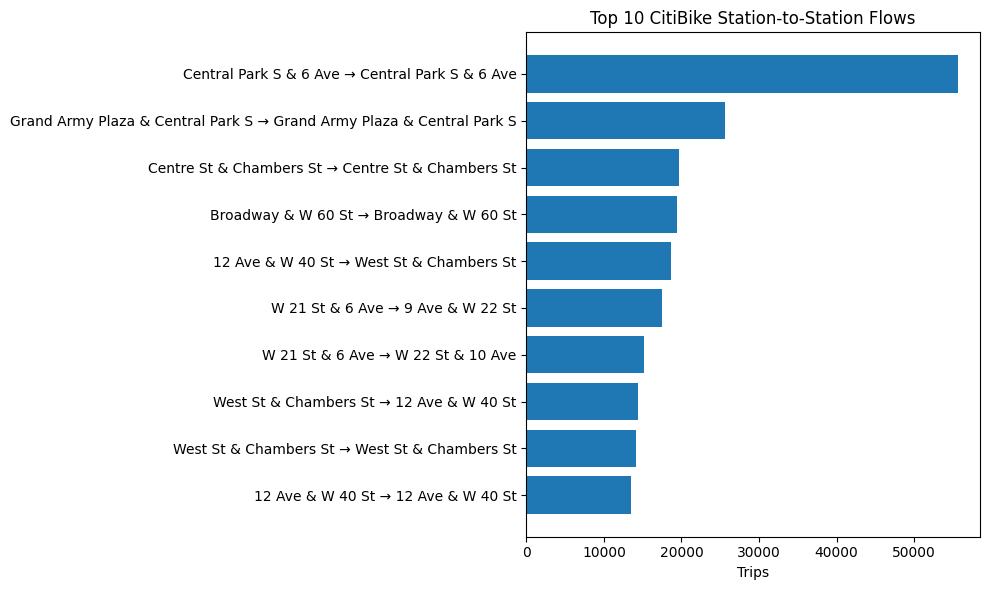

In [6]:
import matplotlib.pyplot as plt

# Define your query — example: Citbike Trip dataset
query = """
SELECT
  start_station_name,
  end_station_name,
  COUNT(*) AS trip_count
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE end_station_name <> ''
GROUP BY
  start_station_name,
  end_station_name
ORDER BY
  trip_count DESC
LIMIT
  10;

"""

# Run the query
pair_query_job = client.query(query)

# Convert to pandas DataFrame
results = pair_query_job.to_dataframe()

# ── 1.  Prep a label for each pair ────────────────────────────
results["pair"] = results["start_station_name"] + " → " + results["end_station_name"]

# Keep the pairs in descending order of trips for plotting
results = results.sort_values("trip_count", ascending=True)   # ascending so largest ends up on top in h‑bar

# ── 2.  Plot ─────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
plt.barh(results["pair"], results["trip_count"])
plt.xlabel("Trips")
plt.title("Top 10 CitiBike Station‑to‑Station Flows")
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


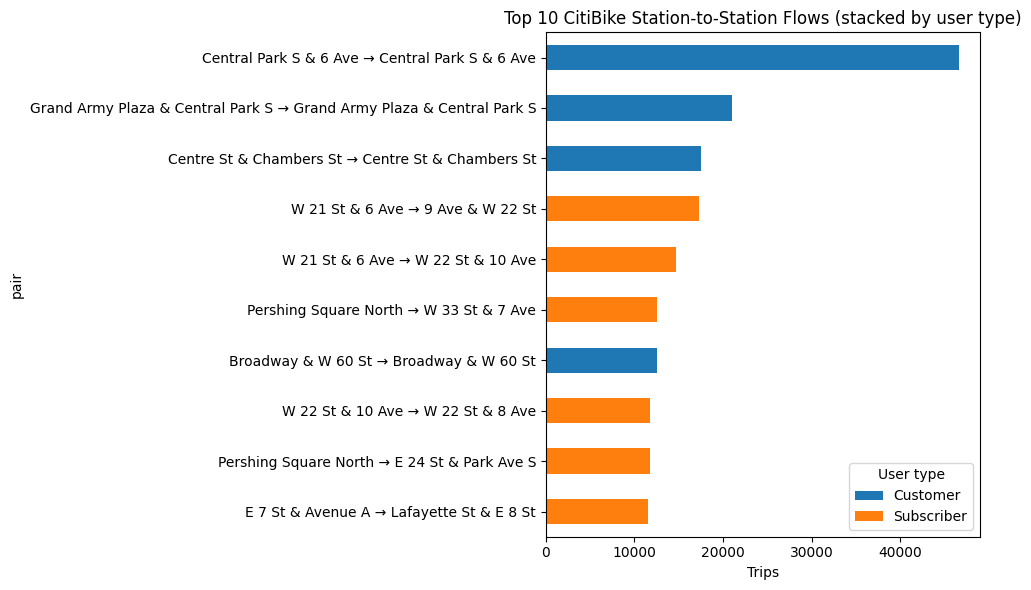

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Define your query — example: Citbike Trip dataset
query = """
SELECT
  start_station_name,
  end_station_name,
  usertype,
  COUNT(*) AS trip_count
FROM
  `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE end_station_name <> ''
GROUP BY
  start_station_name,
  end_station_name,
  usertype
ORDER BY
  trip_count DESC
LIMIT
  10;

"""

# Run the query
pair_query_job = client.query(query)

# Convert to pandas DataFrame
results = pair_query_job.to_dataframe()

# ── 1.  Build a compact label for each station pair ────────────────
results["pair"] = results["start_station_name"] + " → " + results["end_station_name"]

# ── 2.  Pivot so each user type gets its own column ────────────────
pivot = (
    results
      .pivot_table(index="pair", columns="usertype", values="trip_count", aggfunc="sum")
      .fillna(0)
)

# Sort by the total trips so the bars line up from smallest (bottom) to biggest (top)
pivot = pivot.assign(total=pivot.sum(axis=1)).sort_values("total", ascending=True)
pivot = pivot.drop(columns="total")   # we don’t need the helper column any more

# ── 3.  Plot a stacked horizontal bar chart ────────────────────────
pivot.plot(
    kind="barh",
    stacked=True,
    figsize=(10, 6),
)

plt.xlabel("Trips")
plt.title("Top 10 CitiBike Station‑to‑Station Flows (stacked by user type)")
plt.legend(title="User type")
plt.tight_layout()
plt.show()

In [170]:
# Define your query — example: Citbike Trip dataset
query = """

WITH monthly AS (
  SELECT
    start_station_id                 AS station_id,
    start_station_name               AS station_name,
    usertype,
    DATE_TRUNC(DATE(starttime), MONTH) AS trip_month,
    COUNT(*)                         AS monthly_trips
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  GROUP BY station_id, station_name, usertype, trip_month
),

avg_monthly AS (
  SELECT
    station_id,
    station_name,
    usertype,
    AVG(monthly_trips) AS avg_monthly_trips       -- ← average over all months
  FROM monthly
  GROUP BY station_id, station_name, usertype
),

ranked AS (
  SELECT
    *,
    RANK() OVER (PARTITION BY station_id
                 ORDER BY avg_monthly_trips DESC) AS rank_within_station
  FROM avg_monthly
)

SELECT
  station_id,
  station_name,
  usertype,
  avg_monthly_trips
FROM ranked
WHERE rank_within_station = 1            -- keep the higher‑volume user type
ORDER BY avg_monthly_trips DESC;

"""

# Run the query
volume_query_job = client.query(query)

# Convert to pandas DataFrame
results = volume_query_job.to_dataframe()
print(results.head())      # look at a few rows

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   station_id            station_name    usertype  avg_monthly_trips
0        <NA>                                           5.828994e+06
1         519   Pershing Square North  Subscriber       1.055746e+04
2        3263  Cooper Square & E 7 St  Subscriber       7.751000e+03
3         521         8 Ave & W 31 St  Subscriber       7.397970e+03
4         497      E 17 St & Broadway  Subscriber       7.275547e+03


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
/var/folders/nm/dc639mrx6s90bqg3vn0khw9c0000gn/T/ipykernel_85086/2667297260.py:67: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


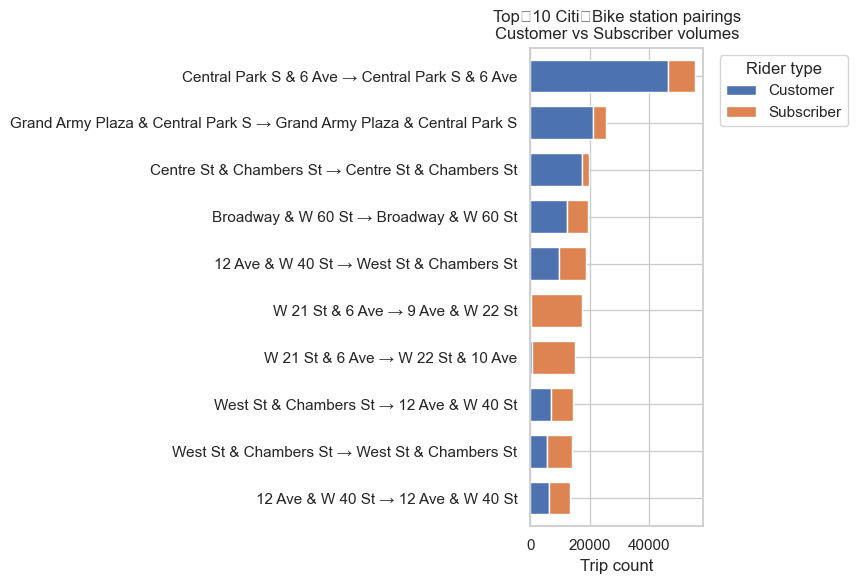

In [181]:
# Define your query — example: Citbike Trip dataset
query = """
-- top_10_pairs_no_nulls.sql
WITH pair_counts AS (
  SELECT
    start_station_name,
    end_station_name,
    usertype,
    COUNT(*) AS trip_count
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE
        start_station_name IS NOT NULL
    AND end_station_name   IS NOT NULL
    AND TRIM(start_station_name) <> ''
    AND TRIM(end_station_name)   <> ''
  GROUP BY start_station_name, end_station_name, usertype
),

top_pairs AS (
  SELECT
    start_station_name,
    end_station_name,
    SUM(trip_count) AS total_trips
  FROM pair_counts
  GROUP BY start_station_name, end_station_name
  ORDER BY total_trips DESC
  LIMIT 10
)

SELECT
  p.start_station_name,
  p.end_station_name,
  p.usertype,
  p.trip_count
FROM pair_counts p
JOIN top_pairs t
  USING (start_station_name, end_station_name);

"""

import seaborn as sns
import matplotlib.pyplot as plt

df  = client.query(query).to_dataframe()

df['pair'] = df['start_station_name'] + ' → ' + df['end_station_name']
plot_df = (
    df.pivot(index='pair', columns='usertype', values='trip_count')
      .fillna(0)
)

order = plot_df.sum(axis=1).sort_values().index
plot_df = plot_df.loc[order]

sns.set_theme(style="whitegrid")
ax = plot_df.plot(
        kind='barh',
        stacked=True,
        figsize=(9,6),
        width=0.7
)

ax.set_xlabel('Trip count')
ax.set_ylabel('')
ax.set_title('Top 10 Citi Bike station pairings\nCustomer vs Subscriber volumes')
ax.legend(title='Rider type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1965: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


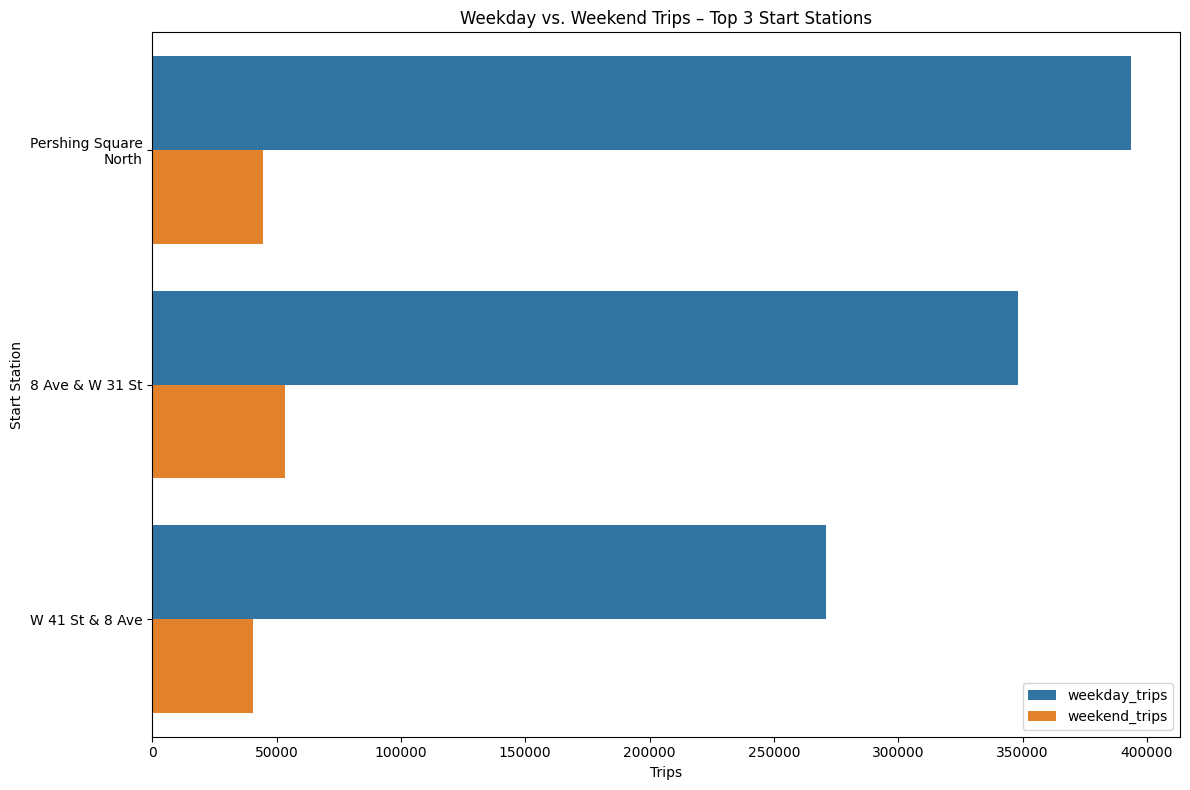

In [11]:
# Define your query — example: Citbike Trip dataset
query = """
WITH day_type_counts AS (
  SELECT
    start_station_name,
    CASE
      WHEN EXTRACT(DAYOFWEEK FROM starttime) IN (1, 7) THEN 'weekend'
      ELSE 'weekday'
    END AS day_type,
    COUNT(*) AS trip_count
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE start_station_name IS NOT NULL AND start_station_name <> ''
  GROUP BY start_station_name, day_type
),

pivoted AS (
  SELECT
    start_station_name,
    SUM(CASE WHEN day_type = 'weekday' THEN trip_count ELSE 0 END) AS weekday_trips,
    SUM(CASE WHEN day_type = 'weekend' THEN trip_count ELSE 0 END) AS weekend_trips
  FROM day_type_counts
  GROUP BY start_station_name
)

SELECT
  start_station_name,
  weekday_trips,
  weekend_trips,
  ABS(weekday_trips - weekend_trips) AS usage_diff
FROM pivoted
ORDER BY usage_diff DESC
LIMIT 3
"""

# Run the query
day_query_job = client.query(query)

# Convert to pandas DataFrame
results = day_query_job.to_dataframe()

viz = (
    results
      .assign(station=lambda d: d['start_station_name'].str.wrap(20))  # tidy long station names
      .melt(id_vars='station',
            value_vars=['weekday_trips', 'weekend_trips'],
            var_name='day_type',
            value_name='trip_count')
)

# ─── 2) Side‑by‑side bars (weekday vs weekend) ───────────────────
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(
    data=viz,
    y='station',              # stations down the y‑axis
    x='trip_count',
    hue='day_type',           # two bars per station
    dodge=True)
plt.title('Weekday vs. Weekend Trips – Top 3 Start Stations')
plt.xlabel('Trips')
plt.ylabel('Start Station')
plt.legend(title='')
plt.tight_layout()
plt.show()